# Question A4

In this section, we will understand the utility of such a neural network in real world scenarios.

#### Please use the real record data named ‘record.wav’  as a test sample. Preprocess the data using the provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.
Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons.
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)



1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

To reduce repeated code, place your
network (MLP defined in QA1)
torch datasets (CustomDataset defined in QA1)
loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.


In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn
class MLP(MLP):
    def __init__(self):
        nn.Module.__init__(self)
        self.mlp_stack = nn.Sequential()

    def add_layer(self, name, layer):
        self.mlp_stack.add_module(name, layer)

2. Install and import shap

In [3]:
# YOUR CODE HERE
!pip install shap
import shap


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: D:\Program Files\Python310\python.exe -m pip install --upgrade pip


3. Read the csv data preprocessed from 'record.wav', using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [4]:
df = 0
size_row = 0
size_column = 0
# YOUR CODE HERE
df = pd.read_csv('new_record.csv')
size_row = df.shape[0]
size_column = df.shape[1]

 4.  Preprocess to obtain the test data, save the test data as numpy array.

In [5]:

def preprocess(X_train, df):
    """preprocess your dataset to obtain your test dataset, remember to remove the 'filename' as Q1
    """
    # YOUR CODE HERE
    # drop useless columns for df
    columns_to_drop = ['filename']
    df = df.drop(columns=columns_to_drop)

    # scale the data
    scaler = preprocessing.StandardScaler()

    scaler.fit(X_train)
    X_test_scaled_eg = scaler.transform(df)

    return X_test_scaled_eg

from common_utils import split_dataset

# preprocess old training and testing data
old_df = pd.read_csv('simplified.csv')
old_df['label'] = old_df['filename'].str.split('_').str[-2]
columns_to_drop = ['filename', 'label']

# perform data splitting first
X_train, y_train, X_test, y_test = split_dataset(old_df, columns_to_drop=columns_to_drop, test_size=0.25, random_state=100)

X_test_scaled_eg = preprocess(X_train, df)

5. Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [6]:
# YOUR CODE HERE
# set path
model_path = 'model.pth'

# initialize model
optimal_combination = [256, 256, 128]
no_features = 77 # feature number
no_labels = 1  # output label number
lr = 0.001  # learning rate

# initialize model
model = MLP()
para_list = []
optimal_combination.insert(0, no_features)
optimal_combination.append(no_labels)
for i in range(len(optimal_combination) - 1):
    para_list.append((optimal_combination[i], optimal_combination[i + 1]))
for j in range(len(para_list)):
    if j == len(para_list) - 1:
        model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
        model.add_layer(f"Sigmoid{j}", nn.Sigmoid())
    else:
        model.add_layer(f"Linear{j}", nn.Linear(*para_list[j]))
        model.add_layer(f"ReLU{j}", nn.ReLU())
        model.add_layer(f"Dropout{j}", nn.Dropout(0.2))

# load model
model.load_state_dict(torch.load(model_path))
model.eval()

# test
X_test_scaled = torch.tensor(X_test_scaled_eg, dtype=torch.float)
res = model(X_test_scaled).squeeze()
pred_label = int(res > 0.5)

In [7]:
print(float(res))
print(f"predicted result: {pred_label}")

0.04047171398997307
predicted result: 0


6. Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)


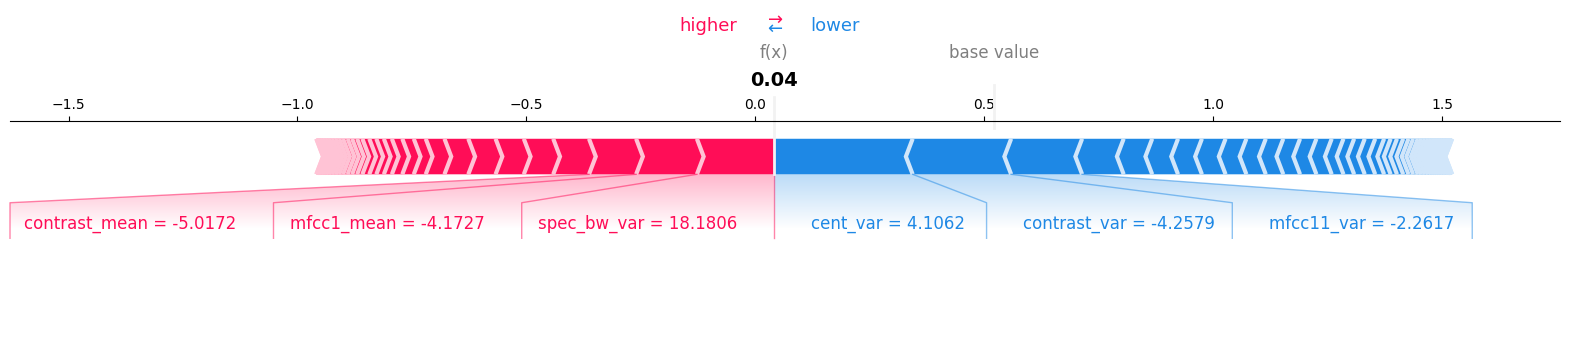

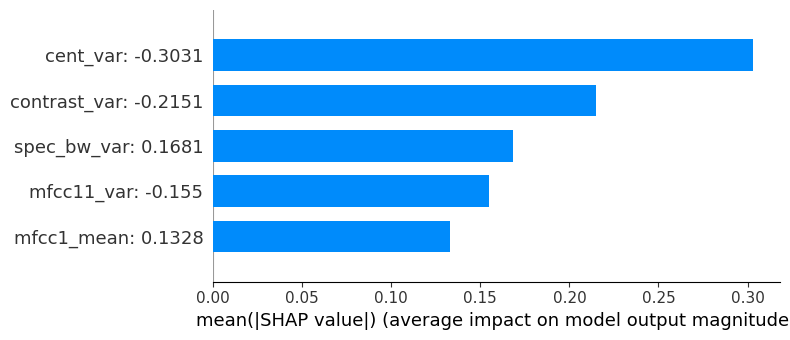

In [8]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# YOUR CODE HERE
col_names = old_df.drop(columns=columns_to_drop).columns.tolist()
X_test_scaled_df = pd.DataFrame(X_test_scaled_eg, columns=col_names)

# scale the training data
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# compute SHAP values for the test data

e = shap.DeepExplainer(model, torch.tensor(X_train_scaled, dtype=torch.float))
values = e.shap_values(torch.tensor(X_test_scaled_eg, dtype=torch.float)).reshape(-1)

# force plot
shap.force_plot(e.expected_value, values, X_test_scaled_df.round(4), feature_names=col_names, matplotlib=True)

# find the top 5 most important features
top_5_idx = np.argsort(np.abs(np.array(values)))[::-1][:5]
top_5_names = [col_names[i] for i in top_5_idx]
top_5_values = [values[i] for i in top_5_idx]
feature_names = [i + ": " + str(j.round(4)) for i, j in zip(top_5_names, top_5_values)]

shap.summary_plot(np.array(values[top_5_idx]).reshape(1, -1), plot_type='bar', feature_names=feature_names)

Explanation:
The force plot gives the direction and tendency of how different variables contribute to the output of a test data comparing to the base value. The blue one means the corresponding variable pushes the value in the negative direction, while the red one means it adds up the output value to make it positive.

We can see the final predicted value of the test record sound is 0.04. Therefore, the predicted label is 0, which means the sound presents negative emotions. Since the value is near zero, it shows the prediction is relatively solid.

Top 5 most important features:
1. cent_var (-0.3031): Variance of Spectral Centroid. It measures how close the sound is to the average frequency of the sound, or to the "center of mass" of a sound's spectrum. It is mostly used to capture the change of the brightness or sharpness of the sound. The value of this variable pushes the prediction in the negative direction about 0.3031 from the base value, which means this variable contributes a lot to the implication of the sound to have negative emotions.

2. contrast_var (-0.2151): Variance of Spectral Contrast. It means the variance in the difference in energy between peaks and valleys in the frequency spectrum, which represents how frequent and large the sound energy changes. The value of this variable pushes the prediction in the negative direction about 0.2151, which also means this variable contributes a lot to the implication of the sound to have negative emotions.

3. spec_bw_var (0.1681): Variance of Spectral Bandwidth. It measures how much the spectral bandwidth values deviate from the average, which indicates how diverse and rich the sound is like. The value of this variable pushes the prediction in the positive direction about 0.2151, implying the clue of the sound to be a little positive.

4. mfcc11_var (-0.155): Variance of the Eleventh Mel-frequency Cepstral Coefficient. It is one of the coefficients extracted from the Mel-frequency cepstral analysis of an audio signal. The value of this variable pushes the prediction in the negative direction about 0.155 from the base value, indicating the sound to be a bit more negative.

5. mfcc1_mean (0.1328): Mean of the First Mel-frequency Cepstral Coefficient. It is also one of the coefficients extracted from the Mel-frequency cepstral analysis of an audio signal. The value of this variable pushes the prediction in the positive direction about 0.1328, indicating the sound to be a bit more positive.

We can know from the plot that some features contribute to the positive side, while others push the predicted value to the negative part of this record sample. The prediction that the model made is the result of aggregating all these features. Finally, the predicted label is negative in this case, implying the sound having negative emotions.